In [4]:
df_1 = pd.read_csv('C:/Users/mi-bi/OneDrive/바탕 화면/data Row/5years_kospi.csv', index_col=0)
df_2 = pd.read_csv('C:/Users/mi-bi/OneDrive/바탕 화면/data Row/5years_kosdaq.csv', index_col=0)
df_raw = pd.concat([df_1,df_2],ignore_index=True)

#### Making Market Timming

In [3]:
import pandas as pd

In [5]:
def making_mt(start,end,code):
    from pykrx import stock
    df = stock.get_index_fundamental(start,end,code)
    df = df.drop(['등락률','PER','선행PER','PBR','배당수익률'],axis=1)
    
    ''' code : KOSPI ('1001') KOSDAQ ('2001') '''
    if code=='1001': 
        df['sma20'] = df['종가'].rolling(20).mean()
        df['mt'] = df['종가']>df['sma20']
        df = df.dropna()
        return df
    elif code=='2001':     
        df['sma3'] = df['종가'].rolling(3).mean()
        df['sma5'] = df['종가'].rolling(5).mean()
        df['sma10'] = df['종가'].rolling(10).mean()
        df['mt'] = ((df['종가']>df['sma3'])|(df['종가']>df['sma5'])|(df['종가']>df['sma10']))
        df = df.dropna()
        return df
    else:
        print('올바른 종목 code 입력')

In [6]:
def making_mt_plot(df,code):
    import matplotlib.pyplot as plt
    from matplotlib import dates
    if code=='1001': 
        plt.figure(figsize = (50, 10))
        plt.title("Kospi Market timming")
        plt.plot(df["종가"])
        plt.plot(df['sma20'])
        plt.scatter(df.loc[df['mt']==1].index, df['종가'][df['mt']==1],
                    color = 'red',
                    label='Go',
                    marker ='^',
                    alpha=0.8)
        plt.scatter(df.loc[df['mt']==0].index, df['종가'][df['mt']==0],
                    color = 'blue',
                    label='Stop',
                    marker ='v',
                    alpha=0.8)
        plt.xticks(rotation=45)
        plt.legend()
        plt.show()
    elif code=='2001':
        plt.figure(figsize = (50, 10))
        plt.title("Kosdaq Market timming")
        plt.plot(df["종가"])
        plt.plot(df['sma3'])
        plt.plot(df['sma5'])
        plt.plot(df['sma10'])
        plt.scatter(df.loc[df['mt']==1].index, df['종가'][df['mt']==1],
                    color = 'red',
                    label='Go',
                    marker ='^',
                    alpha=0.8)
        plt.scatter(df.loc[df['mt']==0].index, df['종가'][df['mt']==0],
                    color = 'blue',
                    label='Stop',
                    marker ='v',
                    alpha=0.8)
        plt.xticks(rotation=45)
        plt.legend()
        plt.show()
    else:
        print('Error : Code check')
    

## 설명 
* backtest 시작 , 끝날짜를 for 문으로 돌린다 ex) for i in range(start,end)  
* 시작 날짜에 maket Timming 이 true면 아래전략 시행  
* sort_vol = 시작 날짜 누적거래대금 범위에 속하는 종목 df로만든다.  output : df_vol
* search momentum signal = df_vol과 df_raw 를 활용하여 Momentum 값을 계산하고 signal을 만든다 
* True 인 종목을 매수한다. 현금계좌잔고 감소 , 보유잔고 증가 (주가*수량)  

<익일>  
* 다음날 보유잔고에 매도 조건을 확인한다 매도조건이 True이면 매도한다. 현금계좌잔고 증가 (당일 종가 * 수량) 보유잔고 감소  
* 매도 후 전일과 같이 위 과정을 반복  

<최종>  
* 수익률 출력  
* MDD 출력 (이전략으로 매매를 했을때 최대 몇% 까지 손실을 보았었는가)  
* 샤프지수출력 (이 전략이아니라 그냥 지수에 투자했을 때에 비해 변동성이 얼마나 큰가 )
* 승률 (이전략을 했을때 + 수익을 본횟수 / 전체횟수)  
* log (활용 무궁무진 : 매수 매도 기록을 전부기록 추후 확률 통계에 기반이됨)  

<고급>
* momentum 지수가 몇일 때 매수를 하면 다음날 상승확률이 가장 높은지 통계적검증 해서 파라미터 조정가능 


#### Making 거래대금조회


In [7]:
def sort_vol(df,date,range):
    df = df[(df['누적거래대금']>=range)&(df['날짜']==date)]
    return df

#### Momentum Search

In [8]:
def search_momentum_signal(df_vol, df_raw):
    li = df_vol['종목명'].values
    dt = df_vol['날짜'].values[0]
    df_vol['Buy'] = None
    df_vol['momentum'] = None
    for i in li:
        today_idx = df_raw[(df_raw['종목명']==i)&(df_raw['날짜']==dt)].index
        day5_idx = df_raw[(df_raw['종목명']==i)&(df_raw['날짜']==dt)].index-5
        momentum = df_raw.loc[today_idx]['종가'].values/df_raw.loc[day5_idx]['종가'].values
        df_vol.loc[df_vol['종목명']==i,'momentum']=momentum[0]
        df_vol.loc[df_vol['종목명']==i,'Buy']=df_vol['momentum']>=1
    return df_vol
        

#### buy signal True 인 종목 매수후 +5일뒤 매도 

In [249]:
df_vol = sort_vol(df_raw,20220104,10000000000)

In [250]:
df_mom = search_momentum_signal(df_vol, df_raw)

C:\Users\mi-bi\AppData\Local\Temp\ipykernel_37524\838232746.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_vol['Buy'] = None
C:\Users\mi-bi\AppData\Local\Temp\ipykernel_37524\838232746.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_vol['momentum'] = None


<AxesSubplot: >

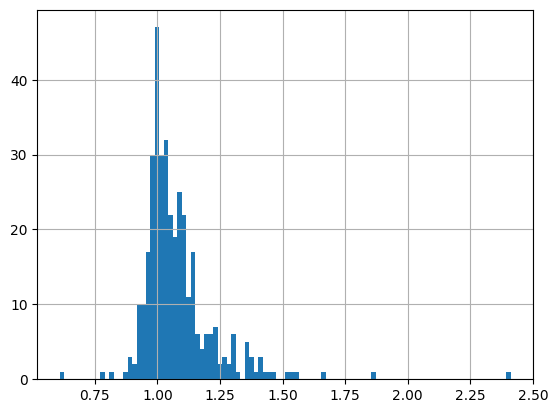

In [251]:
df_mom['momentum'].hist(bins=100)

In [42]:
def buy_list(df_mom):
    buy_list = df_mom[df_mom['Buy']==True]
    return buy_list
    

In [255]:
for i in b_li['종목명'].unique():
    idx = b_li[b_li['종목명']==i].index
    b_li.loc[b_li['종목명']==i,'5일후종가']=df_raw[(df_raw['종목명']==i)&(df_raw.index==idx[0]+5)]['종가'].values[0]
    

C:\Users\mi-bi\AppData\Local\Temp\ipykernel_37524\650286458.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  b_li.loc[b_li['종목명']==i,'5일후종가']=df_raw[(df_raw['종목명']==i)&(df_raw.index==idx[0]+5)]['종가'].values[0]


In [40]:
date = date[20:23]

In [26]:
import numpy as np

In [54]:
result = pd.DataFrame()
for i in date:
    df_vol = sort_vol(df_raw,i,10000000000)
    df_mom = search_momentum_signal(df_vol, df_raw)
    df_buy = buy_list(df_mom)
    result = result.append(df_buy)
    

C:\Users\mi-bi\AppData\Local\Temp\ipykernel_38368\838232746.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_vol['Buy'] = None
C:\Users\mi-bi\AppData\Local\Temp\ipykernel_38368\838232746.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_vol['momentum'] = None
C:\Users\mi-bi\AppData\Local\Temp\ipykernel_38368\1051114659.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result = result.append(df_buy)
C:\Users

In [63]:
result

,날짜,종가,시가,최고가,최저가,누적거래량,누적거래대금,종목명,Buy,momentum
3717,20221216,13250,13600,15250,13200,6862443,97139155100,케이카,True,1.039216
4033,20221216,118500,115500,120000,115000,151048,17923527000,현대중공업,True,1.021552
4352,20221216,5390,5190,5640,5080,4801238,26029837040,SK리츠,True,1.036538
6366,20221216,183500,177000,183500,176000,252456,45717121000,크래프톤,True,1.01662
11544,20221216,85500,83500,85500,82100,302516,25344411100,SK바이오사이언스,True,1.031363
...,...,...,...,...,...,...,...,...,...,...
2409351,20221220,28600,29100,29100,27900,353806,10061695300,다우데이타,True,1.021429
2427546,20221220,4330,3985,4480,3920,22945430,98651642245,SCI평가정보,True,1.157754
2477279,20221220,950,848,1035,848,18104298,17804937422,원풍물산,True,1.24183
2497900,20221220,38700,36400,40200,35300,1957371,74645681400,양지사,True,1.133236


In [64]:
for i in result['종목명'].unique():
    idx = result[result['종목명']==i].index
    result.loc[result['종목명']==i,'5일후종가']=df_raw[(df_raw['종목명']==i)&(df_raw.index==idx[0]+5)]['종가'].values[0]

In [66]:
result['수익률']=(result['5일후종가']-result['종가'])/result['종가']*100

In [70]:
# 해당전략으로 3일 매매했을 때 평균수익률 (거래비용 제외..)
result['수익률'].mean()

-3.526213020380843

In [74]:
#해당 코스피지수 수익률
(2356.73-2360.02)/2360.02

-0.0013940559825764034